In [1]:
# Run it once and Comment
# import sys
# sys.path.append('C:\\Shaukat\\code\\functions_implemented')
# print sys.path
# import functions_implemented as fi


In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn import linear_model
from sklearn import preprocessing
from sklearn.preprocessing import PolynomialFeatures
import scipy.stats as stats
from datetime import datetime, timedelta

from keras.models import Sequential
from keras.layers import Dense
from keras.wrappers.scikit_learn import KerasRegressor
from keras.callbacks import ModelCheckpoint, CSVLogger, ReduceLROnPlateau
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import KFold
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.metrics import mean_squared_error
from copy import deepcopy

from keras.models import load_model

%matplotlib inline





Using Theano backend.


In [3]:
# Load the model from file
model = load_model('C://Shaukat//code//rainfall//model_stored//orford//model_lstm_orford_v7.h5')

In [4]:
df_gfs = pd.read_csv("C://Shaukat//code//data_rep//gfs//csv_files//gfs_orford_clipped.csv")
df_bom = pd.read_csv("C://Shaukat//code//data_rep//bom//Orford.csv")

In [5]:
# Setting up GFS
df_gfs['Unnamed: 0'] = pd.to_datetime(df_gfs['Unnamed: 0'])
df_gfs.set_index('Unnamed: 0', inplace = True)

# Setting up BOM
# df_bom['date_only'] = df_bom.UtcTime.dt.date
df_bom.UtcTime = pd.to_datetime(df_bom.UtcTime)
df_bom.set_index('UtcTime', inplace=True)

# Trim df_bom and df_gfs from november 2016
df_bom = df_bom.loc['2016-09-08 00:00:00':]
df_gfs = df_gfs.loc['2016-09-08 00:00:00':]

In [6]:
# df_gfs.head(4)

In [7]:
# df_bom.head(4)

In [8]:
# Prepare groundtruth dataframe from BOM 
tot_gfs_entries = len(df_gfs.index)
df_gt = pd.DataFrame(index=df_gfs.index, columns=['rainfall_t+1','rainfall_t+2','rainfall_t+3'])
for dt_gfs in range(0,tot_gfs_entries):
    # Iterate each date in GFS and get the groundtruth rainfall from BOM
    
    date_a = df_gfs.index[dt_gfs] # Forecast time in gfs (made every three hours)
    date_t1 = date_a + timedelta(hours=1) # rainfall_t+1
    date_t2 = date_a + timedelta(hours=2) # rainfall_t+2
    date_t3 = date_a + timedelta(hours=3) # rainfall_t+3
    print 'processing: ', date_a 

    # df_patch for t+1 (Gather groundtruth rainfall from BOM)
    df_patch = df_bom.loc[date_a:date_t1].copy()
    rainfall_t1 = df_patch.RainfallLast10Minutes.sum()
    print 'date_t1: ', date_t1 

    
    # df_patch for t+2 (Gather groundtruth rainfall from BOM)
    df_patch = df_bom.loc[date_t1:date_t2].copy()
    rainfall_t2 = df_patch.RainfallLast10Minutes.sum()
    print 'date_t2: ', date_t2 

    
    # df_patch for t+3 (Gather groundtruth rainfall from BOM)
    df_patch = df_bom.loc[date_t2:date_t3].copy()
    rainfall_t3 = df_patch.RainfallLast10Minutes.sum()
    print 'date_t3: ', date_t3, '\n' 

    
    # Add it to the groundtruth df
    df_gt.loc[date_a] = [rainfall_t1, rainfall_t2, rainfall_t3]
    

processing:  2016-09-08 00:00:00
date_t1:  2016-09-08 01:00:00
date_t2:  2016-09-08 02:00:00
date_t3:  2016-09-08 03:00:00 

processing:  2016-09-08 03:00:00
date_t1:  2016-09-08 04:00:00
date_t2:  2016-09-08 05:00:00
date_t3:  2016-09-08 06:00:00 

processing:  2016-09-08 06:00:00
date_t1:  2016-09-08 07:00:00
date_t2:  2016-09-08 08:00:00
date_t3:  2016-09-08 09:00:00 

processing:  2016-09-08 09:00:00
date_t1:  2016-09-08 10:00:00
date_t2:  2016-09-08 11:00:00
date_t3:  2016-09-08 12:00:00 

processing:  2016-09-08 12:00:00
date_t1:  2016-09-08 13:00:00
date_t2:  2016-09-08 14:00:00
date_t3:  2016-09-08 15:00:00 

processing:  2016-09-08 15:00:00
date_t1:  2016-09-08 16:00:00
date_t2:  2016-09-08 17:00:00
date_t3:  2016-09-08 18:00:00 

processing:  2016-09-08 18:00:00
date_t1:  2016-09-08 19:00:00
date_t2:  2016-09-08 20:00:00
date_t3:  2016-09-08 21:00:00 

processing:  2016-09-08 21:00:00
date_t1:  2016-09-08 22:00:00
date_t2:  2016-09-08 23:00:00
date_t3:  2016-09-09 00:00:00 



In [9]:
# df_gt.to_csv("check.csv")
# X: df_gfs
# Y: df_gt

In [10]:
# print df_gfs.columns

In [11]:
col_list = ['pred_cloud_cover', 'pred_cloud_cover_bound_cloud_layer',
       'pred_convective_cloud', 'pred_dewp', 'pred_high_tcc',
       'pred_low_tcc', 'pred_lw_rad', 'pred_max_wind_press',
       'pred_merid_wind', 'pred_middle_tcc', 'pred_rain_rate',
       'pred_rel_humidity', 'pred_sunshine', 'pred_surf_geowind', 'pred_surf_momentum_vflux', 'pred_surface_pressure', 'pred_sw_rad',
       'pred_temp', 'pred_total_rain', 'pred_ustorm', 'pred_vstorm',
       'pred_wind_speed_surf', 'pred_zonal_wind']
df_X = df_gfs[col_list].copy()
df_Y = df_gt.copy()

In [12]:
# Make sure that df_X is not null
df_X_bool = df_X.isnull().any().any()
print df_X_bool, 'THIS MUST BE FALSE' # This must be FALSE

# df_X.isnull().any()

False THIS MUST BE FALSE


In [13]:
df_data_matrix = df_X.as_matrix()
df_gt_rainfall_forecast_matrix = df_Y.as_matrix()
print 'Shape of data matrix: ',df_data_matrix.shape
print 'Shape of label matrix: ',df_gt_rainfall_forecast_matrix.shape

# Normalize data matrix with zero mean and unit covariance
# http://scikit-learn.org/stable/modules/preprocessing.html
df_data_matrix = preprocessing.scale(df_data_matrix)

data_matrix = np.copy(df_data_matrix)
label_matrix = np.copy(df_gt_rainfall_forecast_matrix)

sliding_window = 3
tot_samples = data_matrix.shape[0]
sample_dimension = data_matrix.shape[1]
print "Total Sample: ",tot_samples
print "Dimension of each sample: ",sample_dimension
    
# Accumulate examples here in this list
input_lstm = []
label_lstm = []
label_entry = sliding_window

    
for sequence in range(0,tot_samples-sliding_window):
    input_lstm.append(data_matrix[sequence:sequence+sliding_window, :])
    label_lstm.append(label_matrix[label_entry,0:3])
    print "sequence, sequence+sliding_window, label_entry: ",sequence,sequence+sliding_window,label_entry
    label_entry = label_entry + 1


return_data_matrix_lstm = np.array(input_lstm)
return_label_matrix_lstm = np.array(label_lstm)

print "LSTM input: ",return_data_matrix_lstm.shape
print "LSTM output: ",return_label_matrix_lstm.shape

Shape of data matrix:  (847L, 23L)
Shape of label matrix:  (847L, 3L)
Total Sample:  847
Dimension of each sample:  23
sequence, sequence+sliding_window, label_entry:  0 3 3
sequence, sequence+sliding_window, label_entry:  1 4 4
sequence, sequence+sliding_window, label_entry:  2 5 5
sequence, sequence+sliding_window, label_entry:  3 6 6
sequence, sequence+sliding_window, label_entry:  4 7 7
sequence, sequence+sliding_window, label_entry:  5 8 8
sequence, sequence+sliding_window, label_entry:  6 9 9
sequence, sequence+sliding_window, label_entry:  7 10 10
sequence, sequence+sliding_window, label_entry:  8 11 11
sequence, sequence+sliding_window, label_entry:  9 12 12
sequence, sequence+sliding_window, label_entry:  10 13 13
sequence, sequence+sliding_window, label_entry:  11 14 14
sequence, sequence+sliding_window, label_entry:  12 15 15
sequence, sequence+sliding_window, label_entry:  13 16 16
sequence, sequence+sliding_window, label_entry:  14 17 17
sequence, sequence+sliding_window, 

In [14]:
# Prepare test and train points
tot_points = return_data_matrix_lstm.shape[0]
train_points = int(np.floor(0.6*tot_points)) 
test_points = tot_points - train_points
print 'tot_points: ', tot_points, ' train_points: ', train_points, ' test_points: ', test_points

# Generate Train Sequence
x_train = np.copy(return_data_matrix_lstm[0:train_points + 1,:])
y_train = np.copy(return_label_matrix_lstm[0:train_points + 1,:])
# Generate Test Sequence
x_test = np.copy(return_data_matrix_lstm[train_points + 1:tot_points + 1 ,:])
y_test = np.copy(return_label_matrix_lstm[train_points + 1:tot_points + 1 ,:])

print 'x_train_shape: ', x_train.shape, ' y_train_shape: ', y_train.shape
print 'x_test_shape: ', x_test.shape, ' y_test_shape: ', y_test.shape

tot_points:  844  train_points:  506  test_points:  338
x_train_shape:  (507L, 3L, 23L)  y_train_shape:  (507L, 3L)
x_test_shape:  (337L, 3L, 23L)  y_test_shape:  (337L, 3L)


In [15]:
model.evaluate(x_test,y_test)

337/337 [==============================] - 0s     


0.08990277062261405

In [16]:
model.evaluate(x_train,y_train)

507/507 [==============================] - 0s     


0.18862720810729253

In [17]:
vec_test = y_test.flatten()
vec_test = vec_test.reshape((len(vec_test),1))
print vec_test.shape
print 'total test points: ', vec_test.shape[0]

predictions = model.predict(x_test)
pred_vec = predictions.flatten()
pred_vec = pred_vec.reshape((len(pred_vec),1))
print pred_vec.shape


(1011L, 1L)
total test points:  1011
(1011L, 1L)


In [18]:
# Preprocess block
threshold = 0.01
preproc_y = deepcopy(pred_vec)
preproc_y[preproc_y<=threshold] = 0.0

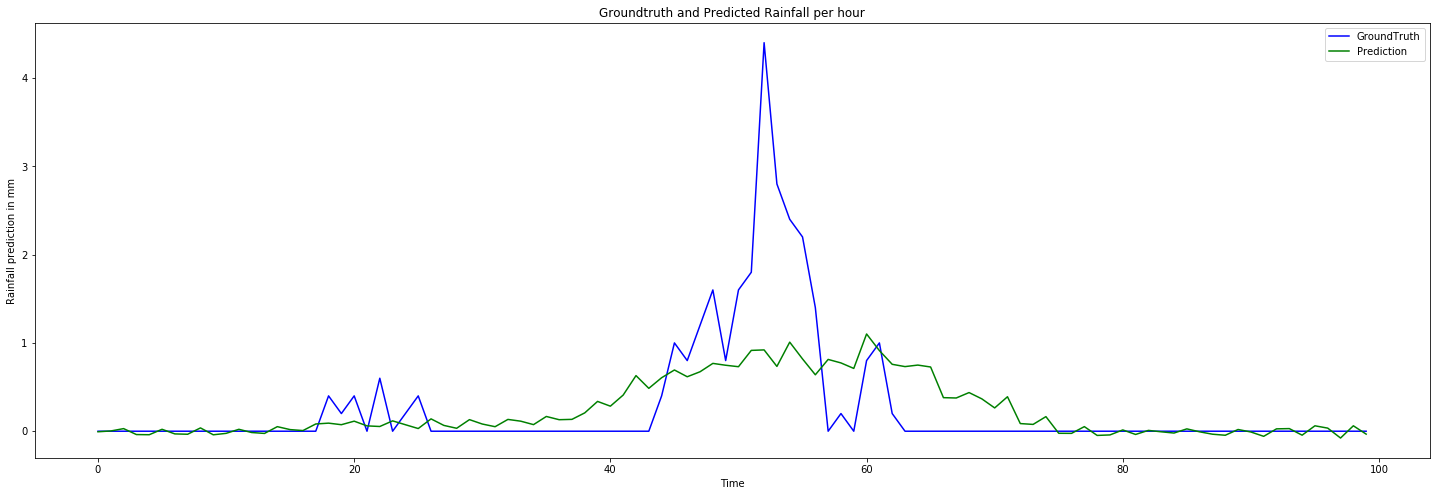

In [20]:
# For plot
time_index = np.arange(0,vec_test.shape[0],1)
time_index = time_index.reshape(((len(time_index),1)))

plt_lower_limit = 0
plt_upper_limit = 100

plt.figure(figsize=(25,8))

# plot

# Full plot
# plt.plot(time_index,vec_test,label="GroundTruth",color='b')
# plt.plot(time_index,pred_vec,label="Prediction",color='g')

# Unpreprocessed Plot
plt.plot(time_index[plt_lower_limit:plt_upper_limit],vec_test[plt_lower_limit:plt_upper_limit],label="GroundTruth",color='b')
plt.plot(time_index[plt_lower_limit:plt_upper_limit],pred_vec[plt_lower_limit:plt_upper_limit],label="Prediction",color='g')

# Preprocessed Plot
# plt.plot(time_index[plt_lower_limit:plt_upper_limit],vec_test[plt_lower_limit:plt_upper_limit],label="GroundTruth",color='b')
# plt.plot(time_index[plt_lower_limit:plt_upper_limit],preproc_y[plt_lower_limit:plt_upper_limit],label="Prediction",color='g')

plt.xlabel('Time')
plt.ylabel('Rainfall prediction in mm')
plt.legend()
plt.title('Groundtruth and Predicted Rainfall per hour')
# img_filename = 'C:\\Users\\ShaukatAbidi\\Documents\\shaukat_python_progs\\learning\\time_series\\feed_forward_nn\\models\\s7_images\\'+str(test_ex)+'.png'
# plt.savefig(img_filename, bbox_inches='tight')
# plt.clf()

In [ ]:
print y_test.shape, predictions.shape

In [ ]:
mean_squared_error(y_test, predictions)

In [ ]:
model.metrics_names

In [ ]:
model.predict(x_test)[0]

In [ ]:
predictions[0]

In [ ]:
model.evaluate(x_test,y_test)

In [ ]:
del model